In [1]:
import pandas as pd
from coclust.coclustering import CoclustMod
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('C:/Users/hp/Desktop/prj_pfe_inwi/data_bts.csv')
# Filtrer les colonnes catégorielles de type 'object'
colonnes_categorielles = data.select_dtypes(include=['object'])

# Afficher les colonnes catégorielles
print(colonnes_categorielles.columns)



Index(['dn', 'contract_id', 'subprofile', 'produit', 'full_secteur',
       'full_city'],
      dtype='object')


In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for colonne in colonnes_categorielles.columns:
    # Encoder la variable catégorielle
    encoded_variable = label_encoder.fit_transform(data[colonne])
    # Assigner les valeurs encodées à la colonne correspondante dans la dataframe
    data[colonne] = encoded_variable

In [4]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

class SphericalKMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iter):
            prev_centroids = self.centroids.copy()
            self.labels = self._assign_labels(X)
            self.centroids = self._update_centroids(X)
            if self._is_converged(prev_centroids):
                break

    def predict(self, X):
        distances = cosine_distances(X, self.centroids)
        return np.argmin(distances, axis=1)

    def _initialize_centroids(self, X):
        random_indices = np.random.choice(range(X.shape[0]), size=self.n_clusters, replace=False)
        return X[random_indices]

    def _assign_labels(self, X):
        distances = cosine_distances(X, self.centroids)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        centroids = np.zeros_like(self.centroids)
        for cluster_idx in range(self.n_clusters):
            cluster_points = X[self.labels == cluster_idx]
            if len(cluster_points) > 0:
                centroids[cluster_idx] = cluster_points.mean(axis=0)
        return centroids

    def _is_converged(self, prev_centroids):
        return np.allclose(self.centroids, prev_centroids, rtol=self.tol)



In [5]:
import pandas as pd

# Créer le DataFrame data1 à partir des colonnes de data
data = pd.DataFrame(data, columns=['produit', 'full_secteur',
       'full_city','full_vol'])

# Afficher le DataFrame data1
print(data.head())


   produit  full_secteur  full_city   full_vol
0       42          6990         12  21.988996
1       58           332         21  20.372895
2       47          7110         12  19.898391
3       57          5341         12   7.545918
4       47           447         21  12.806814


In [6]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


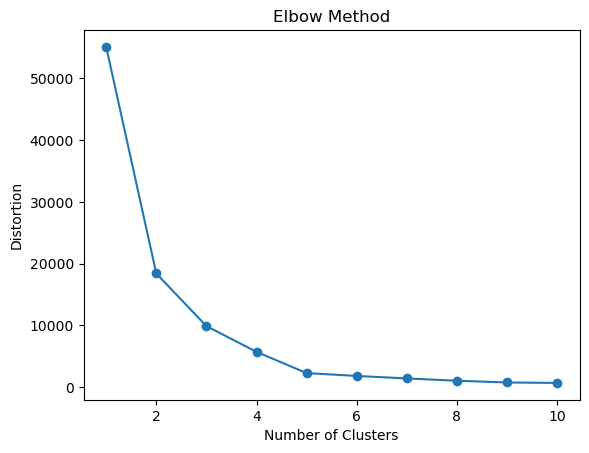

In [7]:
# Importer les modules nécessaires
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# Définir la classe Elbow
class Elbow:
    def __init__(self, max_clusters=10):
        self.max_clusters = max_clusters

    def fit(self, X):
        self.distortions = []
        for num_clusters in range(1, self.max_clusters + 1):
            spherical_kmeans = SphericalKMeans(n_clusters=num_clusters)
            spherical_kmeans.fit(X)
            distortion = self._calculate_distortion(X, spherical_kmeans)
            self.distortions.append(distortion)

    def _calculate_distortion(self, X, spherical_kmeans):
        labels = spherical_kmeans.predict(X)
        centroids = spherical_kmeans.centroids
        distances = pairwise_distances(X, centroids, metric='cosine')
        distortion = 0
        for cluster_idx in range(spherical_kmeans.n_clusters):
            cluster_points = X[labels == cluster_idx]
            cluster_distances = distances[labels == cluster_idx, cluster_idx]
            distortion += np.sum(cluster_distances ** 2)
        return distortion

    def plot_distortions(self):
        plt.plot(range(1, self.max_clusters + 1), self.distortions, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Distortion')
        plt.title('Elbow Method')
        plt.show()

# Utiliser l'algorithme Elbow
elbow = Elbow(max_clusters=10)
elbow.fit(data_scaled)
elbow.plot_distortions()


In [18]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = data.values

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer l'algorithme K-means
n_clusters = 5# Nombre de clusters souhaité
kmeans = SphericalKMeans(n_clusters)
kmeans.fit(X_scaled)

labels = kmeans.predict(X_scaled)

print(labels)


[4 0 4 ... 1 3 0]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Calcul du score de silhouette pour l'ensemble des données
silhouette_avg = silhouette_score(X_scaled,labels)
print("Le score de silhouette moyen est :", silhouette_avg)


Le score de silhouette moyen est : 0.3439824859740299


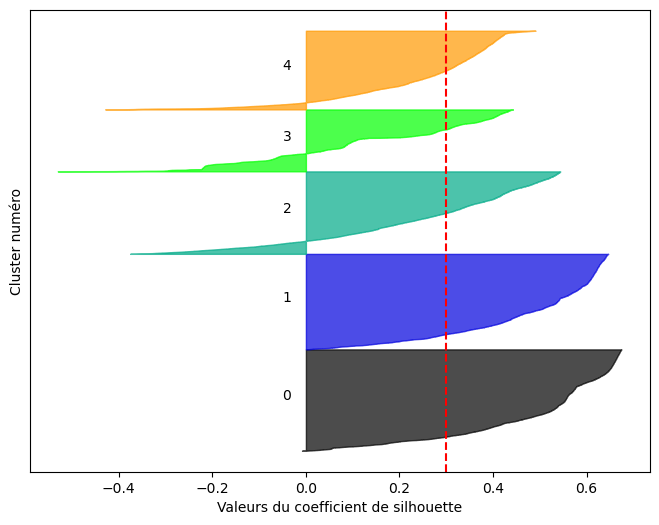

In [19]:
# Calcul des scores de silhouette pour chaque point de données
sample_silhouette_values = silhouette_samples(X_scaled, labels)

# Création d'un graphique en barres pour afficher les scores de silhouette
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(n_clusters):
    # Regroupez les scores de silhouette pour chaque cluster et triez-les
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    # Calculez la hauteur de la barre
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Remplissez le graphique en barres
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
  
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Étiquette pour les clusters
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcul de la prochaine position y_lower pour le prochain graphique
    y_lower = y_upper + 10

plt.xlabel("Valeurs du coefficient de silhouette")
plt.ylabel("Cluster numéro")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Ligne verticale pour le score de silhouette moyen
plt.yticks([])  # Supprimer les numéros de cluster (facultatif)
plt.show()


In [20]:
kmeans.fit(X_scaled)


In [21]:
centroids = kmeans.centroids



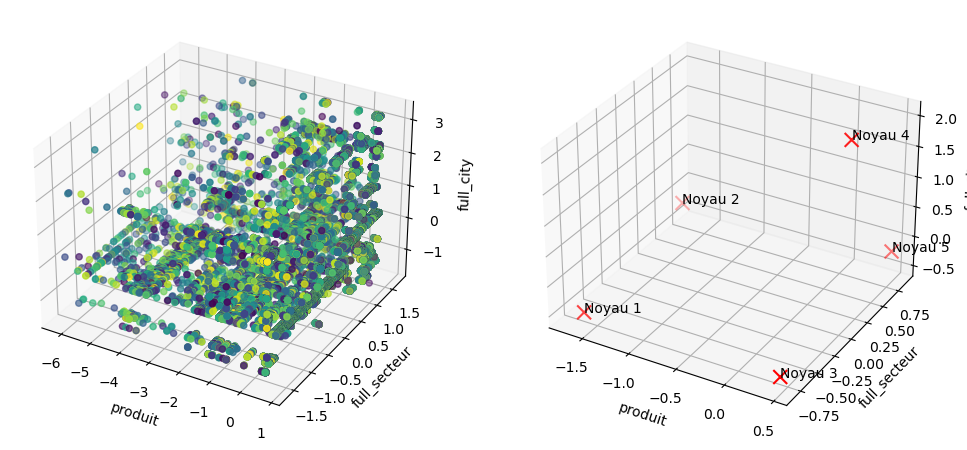

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Afficher les scatter plots des éléments et des noyaux dans la même ligne
fig = plt.figure(figsize=(12, 6))

# Scatter plot des éléments
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=range(len(X_scaled)), cmap='viridis', marker='o')
ax1.set(xlabel='produit', ylabel='full_secteur', zlabel='full_city')

# Scatter plot des noyaux
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=100)
ax2.set(xlabel='produit', ylabel='full_secteur', zlabel='full_city')

# Afficher les noyaux avec un label
for i, centroid in enumerate(centroids):
    ax2.text(centroid[0], centroid[1], centroid[2], f"Noyau {i+1}", color='black', fontsize=10)

plt.show()


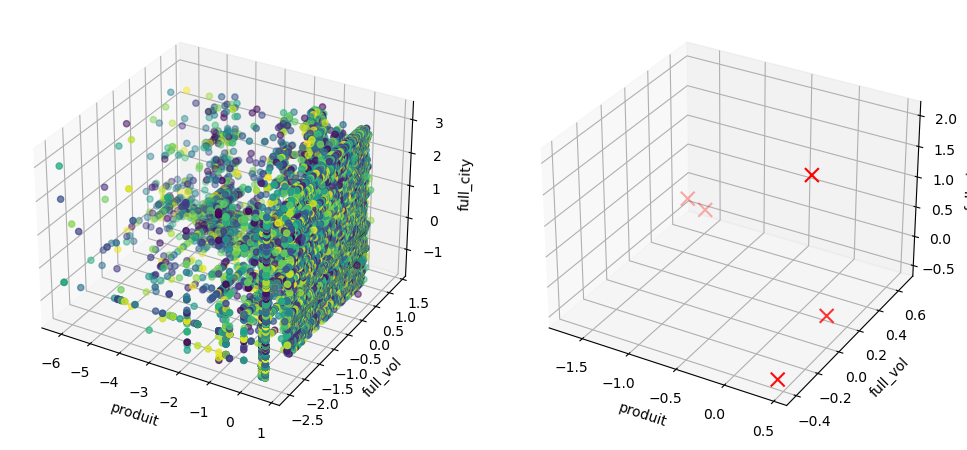

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Afficher les scatter plots des éléments et des noyaux dans la même ligne
fig = plt.figure(figsize=(12, 6))

# Scatter plot des éléments
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_scaled[:, 0], X_scaled[:, 3], X_scaled[:, 2], c=range(len(X_scaled)), cmap='viridis', marker='o')
ax1.set(xlabel='produit', ylabel='full_vol', zlabel='full_city')

# Scatter plot des noyaux
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(centroids[:, 0], centroids[:, 3], centroids[:, 2], c='red', marker='x', s=100)
ax2.set(xlabel='produit', ylabel='full_vol', zlabel='full_city')

"""# Afficher les noyaux avec un label
for i, centroid in enumerate(centroids):
    ax2.text(centroid[0], centroid[1], centroid[2], f"Noyau {i+1}", color='black', fontsize=10)"""

plt.show()


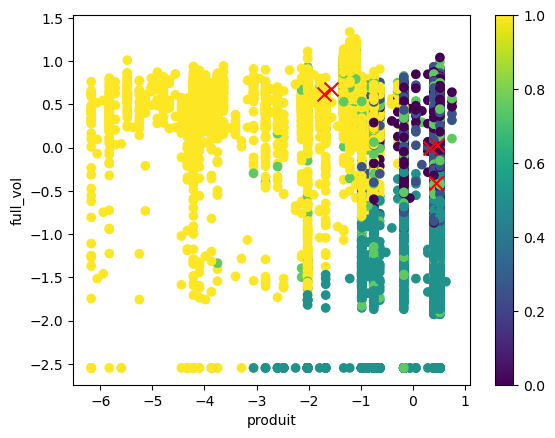

In [24]:
# Créer le scatter plot
plt.scatter(X_scaled[:, 0], X_scaled[:, 3], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 3], c='red', marker='x', s=100)

# Ajouter des labels aux axes
plt.xlabel('produit')
plt.ylabel('full_vol')

# Afficher la légende
plt.colorbar()

# Afficher le scatter plot
plt.show()